In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.utils import check_random_state

In [2]:
# Set the random seed for scikit-learn's SVM
random_seed = 42
random_state = check_random_state(random_seed)

In [3]:
random_state

RandomState(MT19937) at 0x1383AAC40

In [4]:
!ls *TCGA*csv

TCGA_2y_survival_all_genes.csv          TCGA_NatGenet_2y_survival_all_genes.csv


In [5]:
data = pd.read_csv("TCGA_2y_survival_all_genes.csv")
data = data.set_index(data.columns[0])

In [6]:
grn = pd.read_csv("GRN_top_100_20231005_before_after_chemo.csv", index_col=0)

In [7]:
grn.head()

,TFDP1,E2F3,YBX1,IRF7,ZBTB7A,MLX,NFIA,FOXO3,ELF4,ARID3A,...,KLF5,PKNOX1,JUNB,NFIL3,FLI1,HIVEP3,NFATC1,ZEB1,ZNF513,ATF3
0,HMGB1,CAB39,NME1,TSPAN13,DGKZ,RAP1B,FXYD1,DHRS3,TRAF4,IRF8,...,CITED4,JUND,ZFP36,C3,TGFBR2,RGS2,SERPINE2,C1QTNF6,TMEM199,KLF6
1,WDR18,TPM3,RAN,CMPK2,CSNK1G2,CAPZA1,ADD3,ARID5B,RBM38,LY96,...,IGF2BP2,UBE2B,SOCS3,GADD45B,GIMAP1,SH3KBP1,KDM6B,TCF4,RHOB,BCL6
2,LASP1,ICOSLG,OAZ1,MX2,PITPNM1,RAP1A,NFIB,METTL7A,EPHA2,IRF7,...,RAB11FIP4,AHCYL1,EGR1,METRNL,LDB2,CCL4L2,BTBD19,COL1A2,HSP90AA1,GPR137B
3,CALM3,BRI3BP,ETF1,IRF8,MBNL1,ACTB,LTBP4,FZD7,NOL4L,VOPP1,...,RAB3IP,LTBP1,IRF1,NAMPT,CARD8,EGR2,MSRB3,MYO1B,RCC2,IER2
4,HAUS7,ACTR2,RAC1,OAS1,CYLD,GSTO1,METTL7A,DHRS12,KIAA0040,SLC17A9,...,MYLPF,C20orf27,ESR1,FOSL2,GIMAP4,CTSC,FBN1,MMP2,SNX2,ZNF33A


In [8]:
grn_cols = list(grn.columns)

In [9]:
grn_genes = []

for g in grn_cols:
    grn_genes += list(grn[g])

In [10]:
grn_list = grn_cols + grn_genes
print(len(grn_list))

10100


In [11]:
grn_list = list(set(grn_list))
print(len(grn_list))

4974


In [12]:
data_prognosis = data["Two_year_survival"]
data_expression = data.iloc[:,1:]

In [13]:
col_filtered = list(set(grn_list).intersection(data_expression.columns))

In [14]:
data_expression = data_expression[col_filtered]

In [15]:
data = pd.concat([data_prognosis, data_expression], axis=1)

In [16]:
X = data.iloc[:,1:]
y = data["Two_year_survival"]
y = pd.DataFrame(y)

In [17]:
y["Two_year_survival"] = y["Two_year_survival"].replace("Yes", 0)
y["Two_year_survival"] = y["Two_year_survival"].replace("NO", 1)
y_encoded = y["Two_year_survival"]

In [19]:
n_regulon = []
m_gene = []
auc_list = []
accuracy_list = []
f1_list = []

for n in range(100):
    for m in range(100):
        regulons = list(grn.columns[:n+1])
        genes = grn.iloc[:m+1,:n+1].values.flatten().tolist()
        filter_set = list(set(regulons + genes))

        col_filtered = list(set(filter_set).intersection(X.columns))

        X_sub = X[col_filtered]

        # Splitting "Yes" data
        X_train_class_a, X_test_class_a, y_train_class_a, y_test_class_a = train_test_split(
            X_sub[y_encoded == 1], y_encoded[y_encoded == 1], test_size=0.2, random_state=42
        )
        
        # Splitting "NO" data
        X_train_class_b, X_test_class_b, y_train_class_b, y_test_class_b = train_test_split(
            X_sub[y_encoded == 0], y_encoded[y_encoded == 0], test_size=0.2, random_state=42
        )
        
        # Combining the splits to create balanced training and validation sets
        X_train = pd.concat([X_train_class_a, X_train_class_b], axis=0)
        y_train = pd.concat([y_train_class_a, y_train_class_b], axis=0)
        
        X_test = pd.concat([X_test_class_a, X_test_class_b], axis=0)
        y_test = pd.concat([y_test_class_a, y_test_class_b], axis=0)
        
        # Initialize and train SVM model
        svm_model = SVC(kernel='linear', probability=True, random_state=random_state)
        svm_model.fit(X_train, y_train)
        
        # Predict probabilities for the test set
        y_prob = svm_model.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr) #AUC
        auc_list.append(roc_auc)
        
        # Assuming you have already trained the SVM model and predicted the labels
        y_pred = svm_model.predict(X_test)
        
        # Calculate the accuracy
        accuracy = accuracy_score(y_test, y_pred)
        accuracy_list.append(accuracy)
        
        f1 = f1_score(y_test, y_pred)
        f1_list.append(f1)

        n_regulon.append(n+1)
        m_gene.append(m+1)

        print(f"{n+1}_regulons_{m+1}_gene:", f1, roc_auc, accuracy, max(f1_list))

1_regulons_1_gene: 0.0 0.4572649572649573 0.7428571428571429 0.0
1_regulons_2_gene: 0.0 0.35256410256410253 0.7428571428571429 0.0
1_regulons_3_gene: 0.0 0.5758547008547009 0.7428571428571429 0.0
1_regulons_4_gene: 0.0 0.5117521367521368 0.7428571428571429 0.0
1_regulons_5_gene: 0.0 0.5128205128205128 0.7428571428571429 0.0
1_regulons_6_gene: 0.0 0.42307692307692313 0.7428571428571429 0.0
1_regulons_7_gene: 0.0 0.5181623931623932 0.7428571428571429 0.0
1_regulons_8_gene: 0.0 0.5160256410256411 0.7428571428571429 0.0
1_regulons_9_gene: 0.0 0.46794871794871795 0.7428571428571429 0.0
1_regulons_10_gene: 0.0 0.6335470085470085 0.7428571428571429 0.0
1_regulons_11_gene: 0.0 0.4786324786324787 0.7428571428571429 0.0
1_regulons_12_gene: 0.0 0.592948717948718 0.7428571428571429 0.0
1_regulons_13_gene: 0.0 0.5641025641025641 0.7428571428571429 0.0
1_regulons_14_gene: 0.0 0.5566239316239315 0.7428571428571429 0.0
1_regulons_15_gene: 0.0 0.561965811965812 0.7428571428571429 0.0
1_regulons_16_gene

In [20]:
df = {'n_regulon': n_regulon,
    'm_gene': m_gene,
    'auc':auc_list,
    'accuracy':accuracy_list,
    'f1':f1_list}

df = pd.DataFrame(df)

In [21]:
df.to_csv("df_SVM_for_plotting_20231005_before_after_TCGA_only.csv")

In [23]:
df.sort_values(by = 'f1', ascending=False).head(20)

,n_regulon,m_gene,auc,accuracy,f1
1096,11,97,0.746795,0.771429,0.619048
1097,11,98,0.748932,0.771429,0.619048
1098,11,99,0.751068,0.771429,0.619048
980,10,81,0.760684,0.785714,0.615385
982,10,83,0.751068,0.785714,0.615385
1095,11,96,0.737179,0.757143,0.604651
1094,11,95,0.733974,0.757143,0.604651
983,10,84,0.743590,0.771429,0.600000
762,8,63,0.731838,0.757143,0.585366
998,10,99,0.763889,0.757143,0.585366


In [24]:
n = 10
m = 96

regulons = list(grn.columns[:n+1])
genes = grn.iloc[:m+1,:n+1].values.flatten().tolist()
filter_set = list(set(regulons + genes))

col_filtered = list(set(filter_set).intersection(X.columns))

X_sub = X[col_filtered]

# Splitting "Yes" data
X_train_class_a, X_test_class_a, y_train_class_a, y_test_class_a = train_test_split(
X_sub[y_encoded == 1], y_encoded[y_encoded == 1], test_size=0.2, random_state=42
)

# Splitting "NO" data
X_train_class_b, X_test_class_b, y_train_class_b, y_test_class_b = train_test_split(
X_sub[y_encoded == 0], y_encoded[y_encoded == 0], test_size=0.2, random_state=42
)

# Combining the splits to create balanced training and validation sets
X_train = pd.concat([X_train_class_a, X_train_class_b], axis=0)
y_train = pd.concat([y_train_class_a, y_train_class_b], axis=0)

X_test = pd.concat([X_test_class_a, X_test_class_b], axis=0)
y_test = pd.concat([y_test_class_a, y_test_class_b], axis=0)

# Initialize and train SVM model
svm_model = SVC(kernel='linear', probability=True, random_state=random_state)
svm_model.fit(X_train, y_train)

# Predict probabilities for the test set
y_prob = svm_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr) #AUC
#auc_list.append(roc_auc)

# Assuming you have already trained the SVM model and predicted the labels
y_pred = svm_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
#accuracy_list.append(accuracy)

f1 = f1_score(y_test, y_pred)
#f1_list.append(f1)

#n_regulon.append(n+1)
#m_gene.append(m+1)

print(f"{n+1}_regulons_{m+1}_genes done!")

11_regulons_97_genes done!


In [25]:
# Get the coefficients of the linear SVM model
coefficients = svm_model.coef_

# Find the indices of the top 10 features with the highest absolute coefficients
top_feature_indices = np.argsort(np.abs(coefficients))[0][-10:]

# Get the actual top 10 features
top_features = X.columns[top_feature_indices]


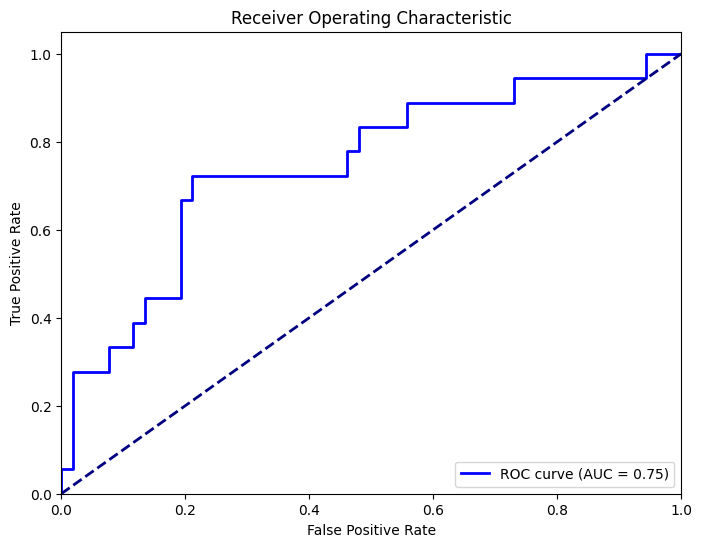

In [26]:
# Predict probabilities for the test set
y_prob = svm_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [27]:
roc_auc

0.7467948717948718

In [28]:
from sklearn.metrics import accuracy_score

# Assuming you have already trained the SVM model and predicted the labels
y_pred = svm_model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.7714285714285715


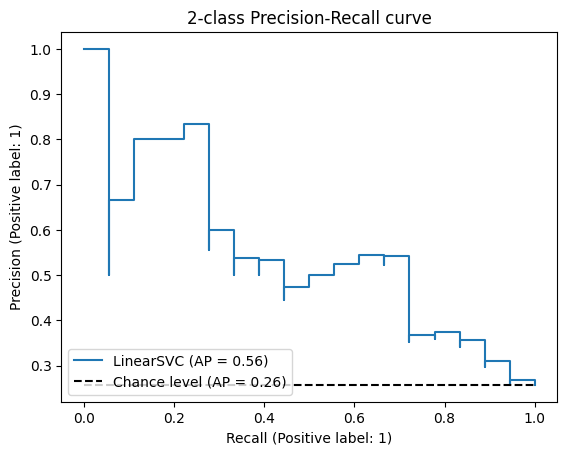

In [29]:
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    svm_model, X_test, y_test, name="LinearSVC", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [30]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)

print("F1 Score:", f1)

F1 Score: 0.619047619047619


In [31]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[41 11]
 [ 5 13]]


In [32]:
f1

0.619047619047619

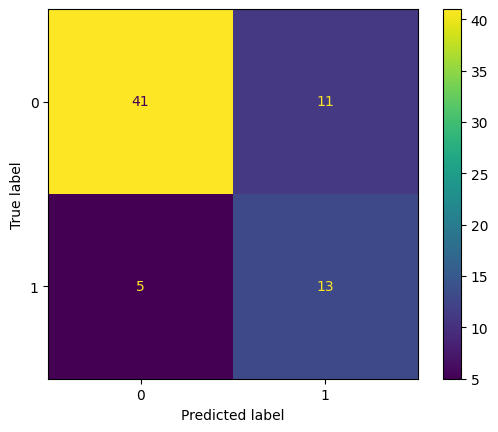

In [33]:
disp = ConfusionMatrixDisplay(confusion_matrix = conf_matrix)
disp.plot()

In [33]:
genes = grn.iloc[:m+1,:n+1]

In [42]:
genes

,TFDP1,FOXO3,SMARCA5,ZNF143,MLX,FOXO1,YBX1,NRF1
0,DNPH1,DHRS3,BAZ1B,TANK,RAP1B,SEMA3C,TOMM5,PHF8
1,PCNA,PPM1N,DRAP1,HERC4,TAOK3,DKK3,ETF1,PITPNM1
2,CENPH,ARID5B,HNRNPA2B1,KDM5A,RAP1A,TSC22D3,MINOS1,KMT2B
3,PHF19,ZFAND5,HNRNPF,SLC18B1,ARPC2,NKD1,DBI,PTPN2
4,LMNB2,F3,XRCC6,PRKAR2A,CAPZA1,ARID5B,NME1,REXO1
...,...,...,...,...,...,...,...,...
59,ELP5,FKBP5,WDR44,NIP7,ORC5,GLIS2,TPRA1,RNF216
60,FBXO5,STX11,STAG2,LINC00342,MAPK7,RUNX3,RPL18A,FCHSD1
61,DESI2,TCEAL4,HNRNPM,CHORDC1,RAP2C,CORO1B,VAMP3,SLC8B1
62,TOP2B,FHIT,FRG1,TDG,PPP1R3B,MPHOSPH8,RSL1D1,KRT10


In [43]:
print(f"{genes.columns[0]}-{genes['TFDP1'][0]}")

TFDP1-DNPH1


In [44]:
all_tf_gene = []

for gene in genes.columns:
    for n in range(len(genes)):
        all_tf_gene.append(f"{gene}-{genes[gene][n]}")

In [45]:
len(all_tf_gene)

512

In [46]:
all_tf_gene

['TFDP1-DNPH1',
 'TFDP1-PCNA',
 'TFDP1-CENPH',
 'TFDP1-PHF19',
 'TFDP1-LMNB2',
 'TFDP1-ZWINT',
 'TFDP1-HMGB1',
 'TFDP1-MAPKBP1',
 'TFDP1-MPC1',
 'TFDP1-NASP',
 'TFDP1-TCF19',
 'TFDP1-LRR1',
 'TFDP1-TYMS',
 'TFDP1-MCM7',
 'TFDP1-FEN1',
 'TFDP1-ETFB',
 'TFDP1-MCM2',
 'TFDP1-MCM6',
 'TFDP1-GINS2',
 'TFDP1-POLA2',
 'TFDP1-PTTG1',
 'TFDP1-ACAT2',
 'TFDP1-LIG1',
 'TFDP1-CDK1',
 'TFDP1-PHKA2',
 'TFDP1-NUDT1',
 'TFDP1-AP3B1',
 'TFDP1-WDHD1',
 'TFDP1-POLD1',
 'TFDP1-EZH2',
 'TFDP1-MVD',
 'TFDP1-FANCG',
 'TFDP1-NUP93',
 'TFDP1-RRM1',
 'TFDP1-PFN1',
 'TFDP1-RCOR1',
 'TFDP1-E2F4',
 'TFDP1-ANP32B',
 'TFDP1-UBE2M',
 'TFDP1-HNRNPM',
 'TFDP1-HIST1H4C',
 'TFDP1-SPCS3',
 'TFDP1-MTHFD1',
 'TFDP1-NCAPG2',
 'TFDP1-OXCT1',
 'TFDP1-DTYMK',
 'TFDP1-GMNN',
 'TFDP1-CALM3',
 'TFDP1-TIMELESS',
 'TFDP1-ABCC4',
 'TFDP1-ANP32E',
 'TFDP1-WRAP53',
 'TFDP1-ELAC2',
 'TFDP1-WDR18',
 'TFDP1-CENPK',
 'TFDP1-ATAD5',
 'TFDP1-FAM171A1',
 'TFDP1-CNOT1',
 'TFDP1-SAFB',
 'TFDP1-ELP5',
 'TFDP1-FBXO5',
 'TFDP1-DESI2',
 'TFDP1-TOP2

In [47]:
all_tf_gene_df = pd.DataFrame(all_tf_gene)

In [49]:
all_tf_gene_df.to_csv("all_tf_gene_df.csv")